In [51]:
suppressMessages(library(survminer))
suppressMessages(library(survival))
suppressMessages(library(forestplot))
suppressMessages(library(ggsci))
suppressMessages(library(dplyr))
suppressMessages(library(adjustedCurves))
suppressMessages(library(tidyverse))

## 0. Funcs
---

In [77]:
getCoef <- function(mod){
    df <- data.frame(summary(mod)$coef)
    df$coef_exp <- signif(exp(df$coef),3)
    df$ci_lower <- signif(exp(df$coef - 1.96 * df$se.coef.),3)
    df$ci_upper <- signif(exp(df$coef + 1.96 * df$se.coef.),3)
    df$HR <- paste(df$coef_exp, " (", df$ci_lower, "-", df$ci_upper, ")", sep="")
    return(data.frame(df))
}

coxSummary <- function(cox_models, var, filt=TRUE){
    i <- 1
    result_list = list()

    for (i in seq_along(cox_models)) {
        formula <- Reduce(paste,deparse(formula(cox_models[[i]])))
        hazard_ratios <- getCoef(cox_models[[i]])$HR
        names(hazard_ratios) <- rownames(getCoef(cox_models[[i]]))

        if (filt==T){
            hazard_ratios <- hazard_ratios[names(hazard_ratios)[grepl(paste0("^", var), names(hazard_ratios))]]
            names(hazard_ratios) <- sub(paste0("^", var), "", names(hazard_ratios))
        }

        df <- data.frame(rbind(hazard_ratios))
        df$Model <- as.character(formula)
        result_list[[i]] <- df
    }
    # Combine all dataframes into one
    results_df <- do.call(rbind, result_list)
    rownames(results_df) <- results_df$Model
    results_df$Model <- NULL

    # Return the dataframe
    return(results_df)

}

getRiskDiff <- function(clust.adjsurv, groupings, times.to.use=c(1,5,10)){
    # Risk Difference Table
    clust.adjci <- clust.adjsurv
    clust.adjci$adjsurv$surv <- 1-clust.adjci$adjsurv$surv

    # Define the desired order of the groups
    order <- groupings

    # Print the reordered dataframe
    result_list = list()

    # For each grouping
    for (i in seq_along(groupings)){
        group_1 = str_split(groupings[[i]], " vs. ")[[1]][1]
        group_2 = str_split(groupings[[i]], " vs. ")[[1]][2]
        result_list[[i]] <- adjusted_curve_diff(clust.adjci, times=times.to.use, group_1=group_1, group_2=group_2, conf_int=TRUE)
        result_list[[i]]$group <- groupings[[i]]
    }

    cd.df <- do.call(rbind, result_list)

    # Percentage
    cd.df$diff <- signif(cd.df$diff*100,3)
    cd.df$ci_lower <- signif(cd.df$ci_lower*100,3)
    cd.df$ci_upper <- signif(cd.df$ci_upper*100,3)
    cd.df$RD <- paste(cd.df$diff, " (", cd.df$ci_lower, "-", cd.df$ci_upper, ")", sep="")
    
    r <- spread(cd.df[,c("time","RD","group")], key = time, value = RD) %>% 
        mutate(group = factor(group, levels = order)) %>%
        arrange(group)

    return(r)
}

getIncidenceGroup <- function(clust.adjsurv, times.to.use=c(1,5,10)){
  clust.adjci <- clust.adjsurv
  clust.adjci$adjsurv$surv <- 1-clust.adjci$adjsurv$surv

  # CI Difference Table
  closest_rows <- list()

  for (i in seq_along(times.to.use)){
    closest_rows[i] <- clust.adjsurv$boot_adjsurv[which.min(abs(clust.adjsurv$boot_adjsurv$time - times.to.use[[i]])), "time"]
  }
  ci.df <- clust.adjsurv$boot_adjsurv[clust.adjsurv$boot_adjsurv$time %in% closest_rows,]
  ci.df$boot_surv <- signif((1-ci.df$boot_surv)*100,3)
  ci.df$ci_upper <- signif((1-ci.df$ci_upper)*100,3)
  ci.df$ci_lower <- signif((1-ci.df$ci_lower)*100,3)
  ci.df$CI <- paste(ci.df$boot_surv, " (", ci.df$ci_upper, "-", ci.df$ci_lower, ")", sep="")

  result.df <- spread(ci.df[,c("time","CI","group")], key = time, value = CI) %>% 
    mutate(group = factor(group)) %>%
    arrange(group)
  
  rownames(result.df) <- result.df$group
  result.df$group <- NULL
  colnames(result.df) <- times.to.use
  return(result.df)
}

getDummy <- function(df, vars){
    dmy <- dummyVars(" ~ .", data = df[,vars,drop=F], fullRank=TRUE)
    cov <- data.frame(predict(dmy, newdata = df[,vars,drop=F]))
    return(cov)
}

## 1. Load Dataset
---

In [4]:
data.df <- read.table("data/processed/AL_with_ccp_03.tsv", sep="\t", header=T, row.names='Code.ID')

# Rename columns
column_mapping <- c("LC.Isotype"="Kappa_or_lambda_PCD", 
                    "BU.Cardiac.Stage"="BU__BNP_based__cardiac_staging",
                    "BMPC.%"="Bone_marrow_plasma_cells____"
                   )

data.df <- data.df %>% rename(!!!column_mapping)

# Filter for time from admission >=0
data.df <- data.df[data.df$time_from_admission>=0,]

# Collapse Race
data.df <- data.df %>%
   mutate(Race = ifelse(Race %in% c('American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'), 'Other', Race))

# Fix NULL values
data.df <- data.df %>% mutate(BU.Cardiac.Stage = ifelse(BU.Cardiac.Stage=="", NA, BU.Cardiac.Stage))
data.df <- data.df %>% mutate(Primary_organ = ifelse(Primary_organ=="", NA, Primary_organ))
data.df <- data.df %>% mutate(LC.Isotype = ifelse(LC.Isotype=="", NA, LC.Isotype))

# assign cluster to var
data.df$m02q3_cluster_n <- factor(data.df$m02q3_cluster_n, levels=c("Low","Intermediate","High"))
data.df <- data.df[complete.cases(data.df[,"m02q3_cluster_n"]),]
data.df$m02q4_cluster_n <- factor(data.df$m02q4_cluster_n, levels=c("Low","Intermediate-Low","Intermediate","High"))
data.df$fna3_cluster_n <- factor(data.df$fna3_cluster_n, levels=c("Low","Intermediate","High"))
data.df$BU.Cardiac.Stage <- as.factor(data.df$BU.Cardiac.Stage)

# As Factor
data.df$LC.Isotype <- as.factor(data.df$LC.Isotype)
data.df$Sex <- as.factor(data.df$Sex)
data.df$Race <- as.factor(data.df$Race)
data.df$Era <- as.factor(data.df$Era)

## 2. KM Curves
---

In [5]:
plotSurv <- function(fit, data.df, legend.title, legend.labs, ...){
    p <- ggsurvplot(
        fit,                    
        data = data.df,
        risk.table = TRUE,
        pval = TRUE,
        conf.int = TRUE,
        xlab = "Time (Yr)",
        risk.table.y.text.col = T,
        risk.table.y.text = F,
        legend.title = legend.title,
        legend.labs = legend.labs,
        ...
    )
    
    return(p)
}

In [5]:
pdf("figures/cluster_fna3_km_curve.pdf", h=8, w=6)
fit <- survfit(Surv(time, status) ~ fna3_cluster_n, data=data.df)
plotSurv(fit, data.df, "Subgroup", NULL, palette=c("#62b67d","#69a9c8","#ca4a29"), 
         surv.median.line="v", xlim = c(0, 12), break.time.by=2)
dev.off()

pdf 
  2

In [6]:
pdf("figures/cluster_m02q3_cluster_n_km_curve.pdf", h=8, w=6)
fit <- survfit(Surv(time, status) ~ m02q3_cluster_n, data=data.df)
plotSurv(fit, data.df, "Subgroup", NULL, palette=c("#62b67d","#69a9c8","#ca4a29"), 
         surv.median.line="v", xlim = c(0, 12), break.time.by=2)
dev.off()

pdf 
  2

In [31]:
pdf("figures/cluster_m02q4_cluster_n_km_curve.pdf", h=8, w=6)
fit <- survfit(Surv(time, status) ~ m02q4_cluster_n, data=data.df)
plotSurv(fit, data.df, "Subgroup", NULL, palette=c("#62b67d","#69a9c8","#9F78AA","#ca4a29"), 
         surv.median.line="v", xlim = c(0, 12), break.time.by=2)
dev.off()

pdf 
  2

## 3. Cox Regressions
---

In [13]:
# Baseline Model
mod.crude <- coxph(Surv(time_from_admission, status) ~ cluster, data=data.df)
mod.baseline <- coxph(Surv(time_from_admission, status) ~ Age + Sex + Race + strata(Era) + LC.Isotype, data=data.df)
cox.zph(mod.baseline)

             chisq df       p
Age        26.6418  1 2.4e-07
Sex         0.0413  1   0.839
Race        4.1336  3   0.247
LC.Isotype  4.8448  1   0.028
GLOBAL     33.9816  6 6.8e-06

In [7]:
# We note that Amyloidogenic light chain & age are time-varying
mod.baseline.t <- coxph(Surv(time_from_admission, status) ~ Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t))

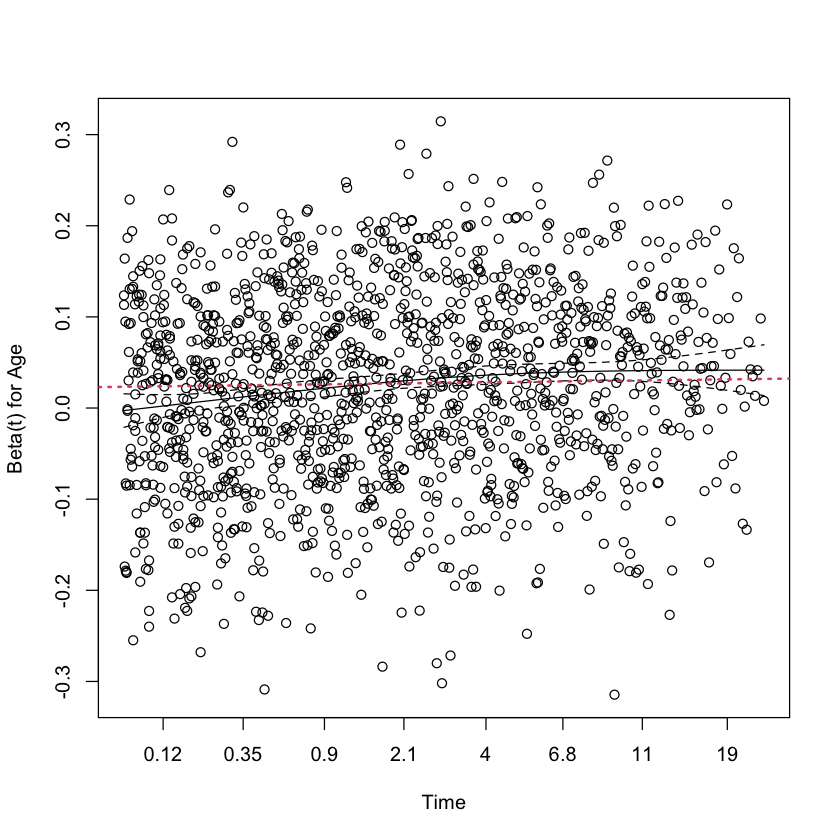

In [8]:
plot(cox.zph(mod.baseline)[1])
abline(coef(mod.baseline.t)[1:2], lwd=2, lty=3, col=2)

In [9]:
data.df$cluster <- data.df$fna3_cluster_n

In [57]:
# Baseline + Cluster
mod.cluster <- coxph(Surv(time_from_admission, status) ~ cluster + Age + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, x=TRUE)

# Baseline + Cluster
mod.stage <- coxph(Surv(time_from_admission, status) ~ BU.Cardiac.Stage + Age + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, x=TRUE)
                
# Baseline + Cluster
mod.cluster.t <- coxph(Surv(time_from_admission, status) ~ cluster + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

# Baseline + BU Cardiac Stage
mod.bu.t <- coxph(Surv(time_from_admission, status) ~ BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

# Baseline + Cluster + BU Cardiac Stage
mod.cluster.bu.t <- coxph(Surv(time_from_admission, status) ~ cluster + BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

# Baseline + Cluster + BU Cardiac Stage
mod.cluster.bu.labs.t <- coxph(Surv(time_from_admission, status) ~ cluster + BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + log(Troponin+1) + log(BNP) + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

In [11]:
mod.cdf <- data.frame(rbind(mod.baseline.t$concordance,mod.cluster.t$concordance, mod.bu.t$concordance, mod.cluster.bu.t$concordance))

mod.cdf$mod <- c("~ Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)",
                 "~ cluster + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)",
                 "~ BU Stage + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)",
                 "~ cluster + BU Stage + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)"

)
mod.cdf

concordant,discordant,tied.x,tied.y,tied.xy,concordance,std,mod
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
185806,143129,3816,149,2,0.5641275,0.009557254,~ Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)
209848,119687,1297,150,1,0.6362640,0.009084543,~ cluster + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)
80825,30285,345,31,0,0.7267283,0.012578502,~ BU Stage + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)
81578,29744,133,31,0,0.7325333,0.012407649,~ cluster + BU Stage + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)


In [12]:
summary(mod.cluster.t)

Call:
coxph(formula = Surv(time_from_admission, status) ~ cluster + 
    Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
    data = data.df, x = TRUE, tt = function(x, t, ...) x * log(t))

  n= 2064, number of events= 1387 
   (7 observations deleted due to missingness)

                        coef exp(coef) se(coef)      z Pr(>|z|)    
clusterIntermediate 0.268512  1.308017 0.062077  4.325 1.52e-05 ***
clusterHigh         0.868841  2.384147 0.073436 11.831  < 2e-16 ***
Age                 0.026678  1.027038 0.002786  9.576  < 2e-16 ***
tt(Age)             0.009500  1.009545 0.001722  5.517 3.45e-08 ***
Sexmale             0.123761  1.131746 0.056253  2.200  0.02780 *  
RaceBlack           0.788712  2.200560 0.267164  2.952  0.00316 ** 
RaceOther           0.768988  2.157581 0.480999  1.599  0.10988    
RaceWhite           0.418497  1.519677 0.253627  1.650  0.09893 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                    exp(coef) ex

In [45]:
summary(mod.cluster.bu.labs.t)

Call:
coxph(formula = Surv(time_from_admission, status) ~ cluster + 
    BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + log(Troponin + 
    1) + log(BNP) + strata(Era) + strata(LC.Isotype), data = data.df, 
    x = TRUE, tt = function(x, t, ...) x * log(t))

  n= 1005, number of events= 508 
   (1066 observations deleted due to missingness)

                               coef exp(coef) se(coef)     z Pr(>|z|)    
clusterIntermediate        0.329684  1.390529 0.112461 2.932  0.00337 ** 
clusterHigh                0.284093  1.328557 0.123155 2.307  0.02107 *  
BU.Cardiac.Stagestage II   0.208662  1.232029 0.191775 1.088  0.27657    
BU.Cardiac.Stagestage III  0.155692  1.168466 0.227107 0.686  0.49300    
BU.Cardiac.Stagestage IIIb 0.427614  1.533594 0.311330 1.374  0.16959    
Age                        0.033918  1.034500 0.005092 6.661 2.71e-11 ***
tt(Age)                    0.005438  1.005453 0.003282 1.657  0.09757 .  
Sexmale                    0.112122  1.118649 0.096212 1.165  0

In [47]:
cox_models <- list(mod.crude, mod.cluster.t, mod.cluster.bu.t, mod.cluster.bu.labs.t)
cox_summary <- coxSummary(cox_models, "cluster")
cox_summary$Low <- "Reference"

# Add events
result <- data.df %>% 
    filter(!is.na(eval(fna3_cluster_n))) %>% 
    group_by(fna3_cluster_n) %>% 
    summarize(Events = sum(status)) %>%
    column_to_rownames(var = "fna3_cluster_n")

cox_summary <- rbind(t(result), cox_summary)
write.table(cox_summary, "Tables/cox_mortality_hr.tsv", sep="\t")

In [56]:
getCoef(mod.cluster.bu.labs.t)[,"HR", drop=F]

,HR
,<chr>
clusterIntermediate,1.39 (1.12-1.73)
clusterHigh,1.33 (1.04-1.69)
BU.Cardiac.Stagestage II,1.23 (0.846-1.79)
BU.Cardiac.Stagestage III,1.17 (0.749-1.82)
BU.Cardiac.Stagestage IIIb,1.53 (0.833-2.82)
Age,1.03 (1.02-1.04)
tt(Age),1.01 (0.999-1.01)
Sexmale,1.12 (0.926-1.35)
RaceBlack,3.27 (1.39-7.66)


In [54]:
getCoef(mod.cluster.bu.labs.t)

,coef,exp.coef.,se.coef.,z,Pr...z..,coef_exp,ci_lower,ci_upper,HR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
clusterIntermediate,0.329684220,1.390529,0.112460898,2.9315453,3.372802e-03,1.39,1.120,1.73,1.39 (1.12-1.73)
clusterHigh,0.284093151,1.328557,0.123155034,2.3067929,2.106637e-02,1.33,1.040,1.69,1.33 (1.04-1.69)
BU.Cardiac.Stagestage II,0.208662286,1.232029,0.191774828,1.0880588,2.765692e-01,1.23,0.846,1.79,1.23 (0.846-1.79)
BU.Cardiac.Stagestage III,0.155691592,1.168466,0.227106715,0.6855438,4.930009e-01,1.17,0.749,1.82,1.17 (0.749-1.82)
BU.Cardiac.Stagestage IIIb,0.427614068,1.533594,0.311330188,1.3735066,1.695949e-01,1.53,0.833,2.82,1.53 (0.833-2.82)
Age,0.033918187,1.034500,0.005091686,6.6614848,2.710749e-11,1.03,1.020,1.04,1.03 (1.02-1.04)
tt(Age),0.005438137,1.005453,0.003282395,1.6567586,9.756828e-02,1.01,0.999,1.01,1.01 (0.999-1.01)
Sexmale,0.112121811,1.118649,0.096211574,1.1653672,2.438704e-01,1.12,0.926,1.35,1.12 (0.926-1.35)
RaceBlack,1.184208448,3.268099,0.434713168,2.7241145,6.447415e-03,3.27,1.390,7.66,3.27 (1.39-7.66)


## 3b. Cox Regression w/ Lab Values

In [14]:
# Baseline + Cluster
mod.labs <- coxph(Surv(time_from_admission, status) ~ cluster + Age + Sex + Race + strata(Era) + strata(LC.Isotype)
                       + log(Troponin+1) + log(BNP) + log(eGFR) + Albumin + log(X24_hr_UTP+1), 
                data=data.df, tt=function(x,t,...) x * log(t))

In [15]:
cox.zph(mod.labs)

                     chisq df       p
cluster             19.183  2 6.8e-05
Age                  2.619  1  0.1056
Sex                  1.020  1  0.3124
Race                 1.036  3  0.7925
log(Troponin + 1)    8.517  1  0.0035
log(BNP)            31.464  1 2.0e-08
log(eGFR)            0.483  1  0.4870
Albumin              0.620  1  0.4312
log(X24_hr_UTP + 1)  2.657  1  0.1031
GLOBAL              49.430 12 1.8e-06

In [16]:
# BNP is time-varying
mod.labs.t <- coxph(Surv(time_from_admission, status) ~ cluster + Age + Sex + Race + strata(Era) + strata(LC.Isotype)
                       + log(Troponin+1) + log(BNP) + tt(BNP) + log(eGFR) + Albumin + log(X24_hr_UTP+1), 
                data=data.df, tt=function(x,t,...) x * log(t))

In [17]:
coef(mod.labs.t)[9:10]

log(BNP)       tt(BNP) 
 0.4025751513 -0.0002032271

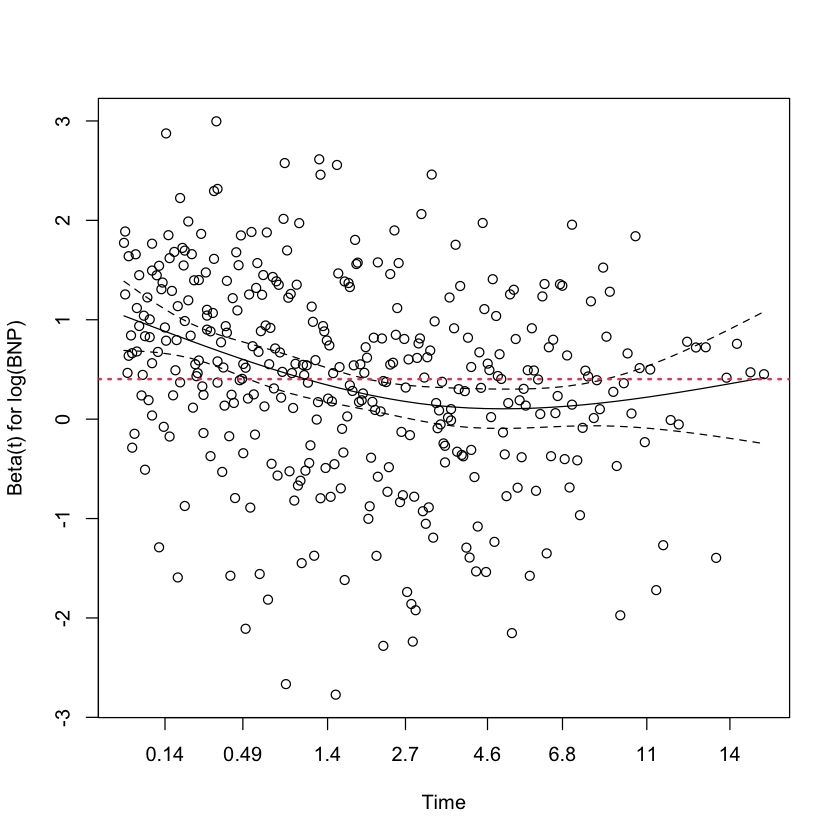

In [18]:
plot(cox.zph(mod.labs)[6])
abline(coef(mod.labs.t)[9:10], lwd=2, lty=3, col=2)

In [19]:
# Renal
mod.renal.labs <- coxph(Surv(time_from_admission, status) ~ cluster + Age + Sex + Race + strata(Era) + strata(LC.Isotype)
                      + log(eGFR) + Albumin + log(X24_hr_UTP+1), 
                data=data.df, tt=function(x,t,...) x * log(t))

In [20]:
cox.zph(mod.renal.labs)

                      chisq df       p
cluster             43.7737  2 3.1e-10
Age                 20.8163  1 5.1e-06
Sex                  0.0685  1    0.79
Race                 5.0892  3    0.17
log(eGFR)            2.2244  1    0.14
Albumin              2.2970  1    0.13
log(X24_hr_UTP + 1)  0.3106  1    0.58
GLOBAL              64.9630 10 4.1e-10

In [21]:
# Renal
mod.renal.labs.t <- coxph(Surv(time_from_admission, status) ~ cluster + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype)
                      + log(eGFR) + Albumin + log(X24_hr_UTP+1), 
                data=data.df, tt=function(x,t,...) x * log(t))

In [22]:
summary(mod.renal.labs.t)

Call:
coxph(formula = Surv(time_from_admission, status) ~ cluster + 
    Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype) + 
    log(eGFR) + Albumin + log(X24_hr_UTP + 1), data = data.df, 
    tt = function(x, t, ...) x * log(t))

  n= 1579, number of events= 1040 
   (492 observations deleted due to missingness)

                         coef exp(coef)  se(coef)      z Pr(>|z|)    
clusterIntermediate  0.097159  1.102035  0.097871  0.993  0.32084    
clusterHigh          0.989162  2.688980  0.091981 10.754  < 2e-16 ***
Age                  0.024189  1.024484  0.003209  7.537 4.80e-14 ***
tt(Age)              0.008489  1.008525  0.001951  4.350 1.36e-05 ***
Sexmale              0.118477  1.125781  0.065405  1.811  0.07007 .  
RaceBlack            0.598489  1.819367  0.283651  2.110  0.03486 *  
RaceOther            0.693644  2.000994  0.575994  1.204  0.22849    
RaceWhite            0.373509  1.452823  0.263542  1.417  0.15641    
log(eGFR)           -0.244368  0.783200  

## 4. Adjusted Survival Curves
---

In [68]:
summary(mod.cluster)

Call:
coxph(formula = Surv(time_from_admission, status) ~ cluster + 
    Age + Sex + Race + strata(Era) + strata(LC.Isotype), data = data.df, 
    x = TRUE)

  n= 2064, number of events= 1387 
   (7 observations deleted due to missingness)

                        coef exp(coef) se(coef)      z Pr(>|z|)    
clusterIntermediate 0.261576  1.298976 0.062045  4.216 2.49e-05 ***
clusterHigh         0.849483  2.338438 0.073211 11.603  < 2e-16 ***
Age                 0.027852  1.028243 0.002771 10.049  < 2e-16 ***
Sexmale             0.121179  1.128827 0.056187  2.157  0.03103 *  
RaceBlack           0.788542  2.200186 0.267127  2.952  0.00316 ** 
RaceOther           0.770446  2.160730 0.480903  1.602  0.10914    
RaceWhite           0.413250  1.511723 0.253542  1.630  0.10312    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                    exp(coef) exp(-coef) lower .95 upper .95
clusterIntermediate     1.299     0.7698    1.1502     1.467
clusterHigh             2

In [69]:
# Adjusted survival curve without bootstrap
clust.adjsurv <- adjustedsurv(data=data.df,
                        variable="cluster",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=mod.cluster,
                        conf_int=T,
                        n_cores=8,
                        n_boot=1000,
                        bootstrap=TRUE
                       )

In [72]:
saveRDS(clust.adjsurv, "data/analysis/subgroup_adjsurv.rds")

In [73]:
pdf("figures/adjusted_surv_clust.pdf")
plot(clust.adjsurv, conf_int=F, custom_colors=c("#62b67d","#69a9c8","#ca4a29"), cif=T) + xlim(0,12.5)
dev.off()

Warning message:
"Removed 246 rows containing missing values (`geom_step()`)."


pdf 
  2

In [71]:
getRiskDiff(clust.adjsurv, c("High vs. Low", "Intermediate vs. Low", "High vs. Intermediate"))

group,1,5,10
<fct>,<chr>,<chr>,<chr>
High vs. Low,22.9 (17.8-28),28.3 (23.1-33.5),23.7 (19.2-28.1)
Intermediate vs. Low,6 (2.55-9.44),8.84 (4.37-13.3),8.58 (3.96-13.2)
High vs. Intermediate,16.9 (11.6-22.2),19.4 (14-24.8),15.1 (10.7-19.5)


In [78]:
getIncidenceGroup(clust.adjsurv)

,1,5,10
,<chr>,<chr>,<chr>
Low,25 (23-27.1),50 (46.8-52.9),66.8 (63.4-70)
Intermediate,31 (28.6-33.6),58.9 (55.7-62.3),75.4 (72.4-78.7)
High,48 (43.6-52.6),78.3 (73.9-82),90.5 (87.3-93.2)


In [37]:
# P-values
adj_test <- adjusted_curve_test(clust.adjsurv, from=0, to=12)
summary(adj_test)

------------------------------------------------------------------
   Test of the Difference between two adjusted Survival Curves
------------------------------------------------------------------

Using the interval: 0 to 12 

                         ABC ABC SE 95% CI (lower) 95% CI (upper) P-Value
Low vs. Intermediate  0.9681 0.2211         0.5516         1.4222       0
Low vs. High          3.0139 0.2567         2.5455         3.5295       0
Intermediate vs. High 2.0458 0.2648         1.5479         2.5674       0
                      N Boot
Low vs. Intermediate     982
Low vs. High             982
Intermediate vs. High    982
------------------------------------------------------------------


In [45]:
pdf("figures/adjusted_surv_clustdiff_intermediate_low.pdf")
plot_curve_diff(clust.adjci, group_1="Intermediate", group_2="Low", conf_int=TRUE, color="blue") + ylim(0,0.4)
dev.off()

pdf 
  2

In [46]:
pdf("figures/adjusted_surv_clustdiff_high_low.pdf")
plot_curve_diff(clust.adjci, group_1="High", group_2="Low", conf_int=TRUE, color="red")+ ylim(0,0.4)
dev.off()

pdf 
  2

In [47]:
pdf("figures/adjusted_surv_clustdiff_high_intermediate.pdf")
plot_curve_diff(clust.adjci, group_1="High", group_2="Intermediate", conf_int=TRUE, color="green")+ ylim(0,0.4)
dev.off()

pdf 
  2

## 4b. BU Stage
---

In [58]:
summary(mod.stage)

Call:
coxph(formula = Surv(time_from_admission, status) ~ BU.Cardiac.Stage + 
    Age + Sex + Race + strata(Era) + strata(LC.Isotype), data = data.df, 
    x = TRUE)

  n= 1078, number of events= 541 
   (993 observations deleted due to missingness)

                               coef exp(coef) se(coef)      z Pr(>|z|)    
BU.Cardiac.Stagestage II   0.764771  2.148503 0.129017  5.928 3.07e-09 ***
BU.Cardiac.Stagestage III  1.039294  2.827221 0.150792  6.892 5.49e-12 ***
BU.Cardiac.Stagestage IIIb 1.843036  6.315685 0.146080 12.617  < 2e-16 ***
Age                        0.033209  1.033767 0.004744  7.000 2.57e-12 ***
Sexmale                    0.105497  1.111262 0.092685  1.138  0.25503    
RaceBlack                  1.131662  3.100806 0.401922  2.816  0.00487 ** 
RaceOther                  0.348493  1.416930 0.636446  0.548  0.58399    
RaceWhite                  0.722433  2.059438 0.383462  1.884  0.05957 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

      

In [63]:
# Adjusted survival curve without bootstrap
bu.adjsurv <- adjustedsurv(data=data.df[complete.cases(data.df['BU.Cardiac.Stage']),],
                        variable="BU.Cardiac.Stage",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=mod.stage,
                        conf_int=T,
                        n_cores=8,
                        n_boot=1000,
                        bootstrap=TRUE
                       )

In [64]:
getIncidenceGroup(bu.adjsurv)

,1,5,10
,<chr>,<chr>,<chr>
stage I,10.4 (12.7-8.28),26.7 (31.9-21.9),43.5 (50.2-36.8)
stage II,21.2 (24.2-18.4),48.1 (52.5-43.7),68.9 (74.2-63.6)
stage III,27 (32.9-21.7),57.6 (66-49.4),77.8 (85.7-70.1)
stage IIIb,49.8 (58.2-41.7),83.4 (90-76.4),94.6 (97.7-90.3)


In [65]:
getRiskDiff(bu.adjsurv)

ERROR: Error in getRiskDiff(bu.adjsurv): could not find function "getRiskDiff"
